# Nanostructures out of equilibrium with KWANT

### © Marko Petrović, University of Delaware
[PHYS824: Nanophysics & Nanotechnology](https://wiki.physics.udel.edu/phys824) 

## What is covered in this notebook
- Two terminal Landauer-Buttiker formula
  - Square lattice (spinless) with temperature smearing.
  - Square lattice with Rashba interaction.
  - Square lattice with disorder and transmission matrix eigenvalues.
  - Ring with AB oscillations.
- Adding custom hopping in KWANT
- Buttiker dephasing.
- Spin Hall effect in four terminal device.
- Topological Hall effect in four terminal device. 


# 1.1 Conductance in a two-terminal square ribbon

First, we need to create a two-terminal ribbon on a square lattice.

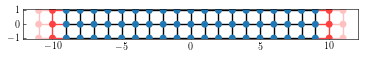

In [594]:
import kwant
import matplotlib.pyplot


def lead_along_x(pos):
    x, y = pos
    width = 3.5
    return abs(y) < 0.5*width 

def system_shape(pos):
    x, y = pos
    width = 3.5
    length = 20.0
    return abs(x) < 0.5*length and abs(y) < 0.5*width

# Build the system
sys = kwant.Builder()
lat = kwant.lattice.square(norbs=1)

v1, v2 = lat.prim_vecs
t = 1.         # Hopping energy

left_direction = kwant.TranslationalSymmetry(-v1)
lead_left = kwant.Builder(left_direction)

# Create main scattering region
sys[lat.shape(system_shape, (0, 0))] = 0.0
sys[lat.neighbors()] = -t

# Create left lead
lead_left[lat.shape(lead_along_x, (0, 0))] = 0.0 
lead_left[lat.neighbors()] = -t

sys.attach_lead(lead_left)
sys.attach_lead(lead_left.reversed())

sys_f = sys.finalized()         # Create finalized sytem
kwant.plot(sys);

### 1.1.1 Transmission and scattering matrix

To calculate transmission in a two-terminal device, use <code>kwant.smatrix</code> object to obtain the scattering matrix at a given energy. The obtained scattering matrix object has a method called <code>transmission</code> which is used to calculate transmission between any pair of the attached leads.

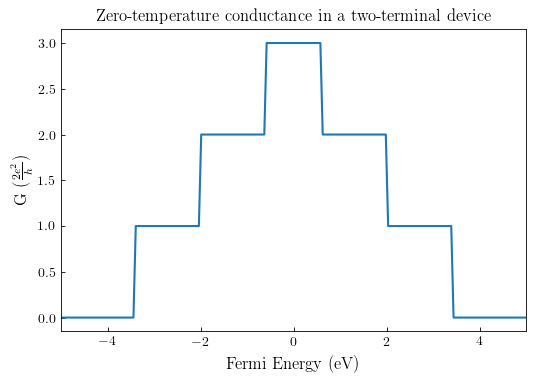

In [603]:
import numpy as np
from matplotlib import pyplot as plt

t10 = []       # Transmission from lead 0 to lead 1
energies = np.linspace(-5, 5, 200)

for energy in energies:
    smatrix = kwant.smatrix(sys_f, energy)

    # Here, we calculate the transmission 
    # from the first lead (left lead) 
    # to the second lead (right lead). 
    # Indexing starts at zero, and it
    # depends on the order in which 
    # the leads were attached. Lead
    # which is attached first will get 
    # the index zero, the one that is
    # attached second will get the index
    # one etc.
    
    # The transmission function is T(E) = Tr[t*t^\dagger]
    # Transmission from the lead 0 to lead 1
    t10.append(smatrix.transmission(1, 0))

t10 = np.array(t10)
plt.figure(dpi=100)
plt.plot(energies, t10, color='C0');
plt.xlabel('Fermi Energy (eV)', fontsize=12);
plt.title('Zero-temperature conductance in a two-terminal device', fontsize=12)
plt.ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=12);
plt.xlim(-5, 5);

### 1.1.2 Temperature smearing of the conductance

Temperature smearing is performed by convolution 
$$ G(T, E_F) = \frac{2e^2}{h}\int_{-\infty}^{+\infty} T(E)
\left(-\frac{\partial f(E)}{\partial E}\right) dE $$ 
with a derivative of the Fermi-Dirac function
  $$ -\frac{\partial f(E)}{\partial E} =  
     \frac{1}{4k_BT}{\rm sech}^2\left(\frac{E-E_{\rm F}}{2k_BT}\right)$$

SUM =  0.9998857350102481
8Kb*T = 0.206808


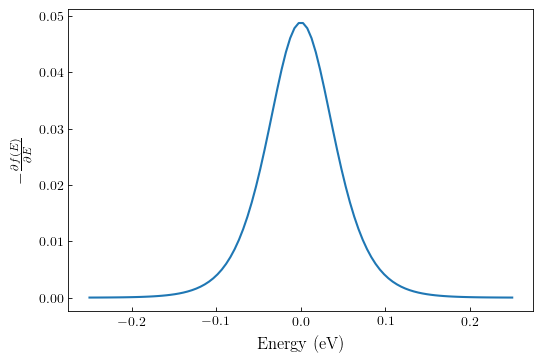

In [604]:
KB = 8.617e-5   # eV / K

def F(energy, ef=0, temp=300.):
    n = 1.0 / (4 * KB * temp)
    return n * (1.0 / np.cosh((energy - ef) / (2*KB*temp)))**2

ens = np.linspace(-0.25, 0.25, 100)
plt.figure(dpi=100)
de = ens[1] - ens[0]
plt.plot(ens, F(ens)*de);
print('SUM = ', (F(ens)*de).sum())
print("8Kb*T =", 8*KB*300)
plt.xlabel('Energy (eV)', fontsize=12);
plt.ylabel(r'$-\frac{\partial f(E)}{\partial E}$', fontsize=12);

Next, we convolute the previously computed conductance with temperature.

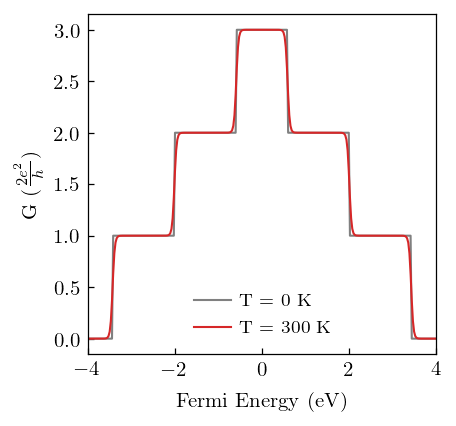

In [605]:
# Compute transmission close to
# one of the steps
t10 = []     
energies = np.linspace(-4, 4, 300)
for energy in energies:
    smatrix = kwant.smatrix(sys_f, energy)
    t10.append(smatrix.transmission(1, 0))
t10 = np.array(t10)


t_conv = []
temperature = 300.
de = energies[1] - energies[0]
for ef in energies:
    df = F(energies, ef=ef, temp=temperature)
    t_conv.append((df*t10*de).sum())

t_conv = np.array(t_conv)
plt.figure(dpi=150, figsize=(3, 3))   # Set figure size in inches
plt.plot(energies, t10, color='gray', lw=1.0, label=r'T = 0 K');
plt.plot(energies, t_conv, color='C3', lw=1.0, label=r'T = 300 K');
plt.legend();
plt.xlim(-4, 4);
plt.xlabel('Fermi Energy (eV)')
plt.ylabel(r'G $(\frac{2e^2}{h}$)');

# 1.2 Rashba spin-orbit coupling

The Rashba Hamiltonian on the square tight-binding lattice of sites ${\bf m} = (m_x, m_y)$  is given by


$$
\hat{H}=\sum_{{\bf m}\sigma} \varepsilon_{\bf m} 
|{\bf m}\sigma\rangle\langle{\bf m}\sigma|+
\sum_{{\bf mm'}
\sigma\sigma'} 
t_{\bf mm'}^{\sigma\sigma'}
|{{\bf m}\sigma}\rangle 
\langle{{\bf m'}\sigma'}|.
$$
 
 Its hopping parameters are non-trivial $2 \times 2$ Hermitian  matrices  ${\bf t}_{\bf m'm}=({\bf t}_{\bf mm'})^\dagger$ in the spin space

$$
{\bf t}_{\bf mm'}=\left\{
\begin{array}{cc}
-t{\bf I}_{\rm 2}-it_{\rm SO}\hat{\sigma}_y &
({\bf m}={\bf m}'+{\bf e}_x)\\
-t{\bf I}_{\rm 2}+it_{\rm SO}\hat{\sigma}_x &  ({\bf m}={\bf m}'+{\bf e}_y)
\end{array}\right.,
$$

First, we need to define unit matrix $I_2$ and Pauli matrices

$I_2 = \left(\begin{matrix} 1 & 0 \\ 0 & 1\end{matrix}\right) $,
$\sigma_x = \left(\begin{matrix} 0 & 1 \\ 1 & 0\end{matrix}\right) $,
$\sigma_y = \left(\begin{matrix} 0 & -i \\ i & 0\end{matrix}\right) $,
$\sigma_z = \left(\begin{matrix} 1 & 0 \\ 0 & -1\end{matrix}\right) $

In [606]:
unit = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

In [578]:
def make_rashba_system(rsoc=1.0, t=1.0, width=3., length=4.):
    
    def lead_along_x(pos):
        x, y = pos
        return (y > 0) and (y <= width) 

    def system_shape(pos):
        x, y = pos
        in_x = (x > 0) and (x <= length)
        in_y = (y > 0) and (y <= width)
        return in_x and in_y
    
    def rashba(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        
        # Check if two sites are connected
        # with hopping along x-direction
        # (Then they have the same y-coordinate)
        hopping_along_x = abs(y2 - y1) < 1.e-6   
        if hopping_along_x: 
            hopping = -t*unit - 1j*rsoc*sigma_y
        else:    # Set hopping along y
            hopping = -t*unit + 1j*rsoc*sigma_x
            
        # Notice that here hoppings are not scalars
        # but [2 x 2] matrices
        return hopping

    # Build the system
    sys = kwant.Builder()
    # Notice that there are now two orbitals per site
    lat = kwant.lattice.square(norbs=2)

    v1, v2 = lat.prim_vecs

    left_direction = kwant.TranslationalSymmetry(-v1)
    lead_left = kwant.Builder(left_direction)

    # Create main scattering region
    sys[lat.shape(system_shape, (1, 1))] = 0*unit
    sys[lat.neighbors()] = rashba

    # Create left lead
    lead_left[lat.shape(lead_along_x, (1, 1))] = 0*unit 
    lead_left[lat.neighbors()] = rashba

    sys.attach_lead(lead_left)
    sys.attach_lead(lead_left.reversed())

    sys_f = sys.finalized()         # Create finalized sytem
    lead_f = lead_left.finalized()  # Create finalized lead
    return sys_f, lead_f

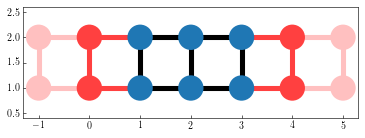

In [607]:
sys, lead = make_rashba_system(width=2, length=3, rsoc=1.0)
kwant.plot(sys);

Next, compute dispersion and transmission in this ribbon

<Figure size 300x300 with 0 Axes>

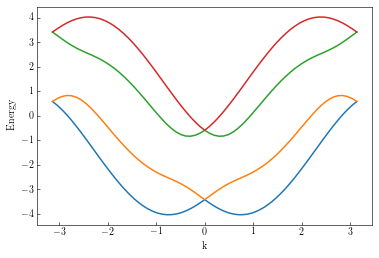

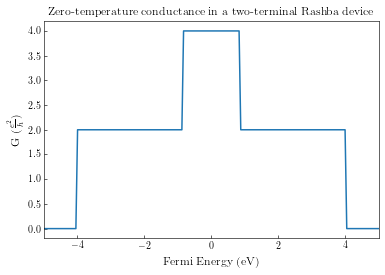

In [610]:
t10 = []       # Transmission from lead 0 to lead 1
energies = np.linspace(-5, 5, 200)

for energy in energies:
    smatrix = kwant.smatrix(sys, energy)
    t10.append(smatrix.transmission(1, 0))
    
plt.figure(dpi=100, figsize=(3, 3));
kwant.plotter.bands(lead);
t10 = np.array(t10)
plt.plot(energies, t10, color='C0');
plt.xlabel('Fermi Energy (eV)', fontsize=12);
plt.title('Zero-temperature conductance in a two-terminal Rashba device',
          fontsize=12);
plt.ylabel(r'G ($\frac{e^2}{h}$)', fontsize=12);
plt.xlim(-5, 5);

# 1.3 Introducing Anderson disorder

The Anderson Hamiltonian on the square tight-binding lattice 
of sites ${\bf m} = (m_x, m_y)$  is given by

$$
\hat{H}=\sum_{{\bf m}} \varepsilon_{\bf m} 
|{\bf m}\rangle\langle{\bf m}|+
\sum_{{\bf mm'}} 
t_{\bf mm'}
|{{\bf m}}\rangle 
\langle{{\bf m'}}|.
$$

The on-site potential is a  uniform random variable
$\varepsilon_{\bf m} \in [-W/2,W/2]$ modeling short range isotropic scattering.

In [548]:
def make_system(w=5, t=-1.0, width=3, length=4):
    
    def lead_along_x(pos):
        x, y = pos
        return (y > 0) and (y <= width) 

    def system_shape(pos):
        x, y = pos
        in_x = (x > 0) and (x <= length)
        in_y = (y > 0) and (y <= width)
        return in_x and in_y
    
    def random_potential(site):
        pot = np.random.random()
        pot_w = w*(2*pot - 1)/2. 
        return pot_w
    
    sys = kwant.Builder()
    lat = kwant.lattice.square(norbs=1)

    v1, v2 = lat.prim_vecs

    left_direction = kwant.TranslationalSymmetry(-v1)
    lead_left = kwant.Builder(left_direction)

    # Create main scattering region
    sys[lat.shape(system_shape, (1, 1))] = random_potential
    sys[lat.neighbors()] = -t

    # Create left lead (no potential disorder)
    lead_left[lat.shape(lead_along_x, (1, 1))] = 0.
    lead_left[lat.neighbors()] = -t

    sys.attach_lead(lead_left)
    sys.attach_lead(lead_left.reversed())
    
    sys_f = sys.finalized()         # Create finalized sytem
    lead_f = lead_left.finalized()  # Create finalized lead
    return sys_f, lead_f

### 1.3.2 Plot onsite potential

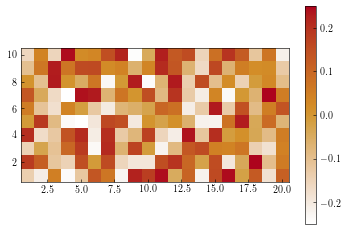

In [612]:
sys, lead = make_system(w=0.5, length=20, width=10)
np.random.seed(5)
h = sys.hamiltonian_submatrix()
v = np.diag(h)
kwant.plotter.map(sys, v.real);

### 1.3.3 Compute conductance using transmission matrix

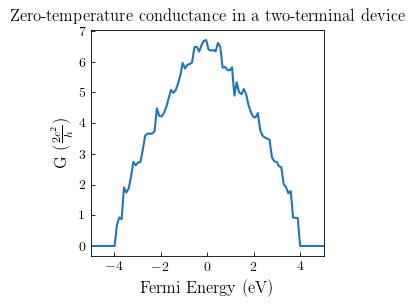

In [613]:
t10 = []       # Transmission from lead 0 to lead 1
energies = np.linspace(-5, 5, 100)

for energy in energies:
    smatrix = kwant.smatrix(sys, energy)
    # Note, you need to set the seed
    # each time you call a solver
    np.random.seed(2) 
    tmat = smatrix.submatrix(1, 0)
    tt = np.dot(tmat, tmat.conj())
    t10.append(np.trace(tt))
    
plt.figure(dpi=100, figsize=(3, 3));
t10 = np.array(t10)
plt.plot(energies, t10, color='C0');
plt.xlabel('Fermi Energy (eV)', fontsize=12);
plt.title('Zero-temperature conductance in a two-terminal device', fontsize=12)
plt.ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=12);
plt.xlim(-5, 5);

### 1.3.4 Eigenvalues of the transmission matrix

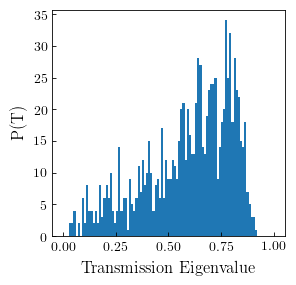

In [614]:

seeds = np.arange(100)  # Do the averaging over 10 distributions
t_evals = []

for seed in seeds:
    smatrix = kwant.smatrix(sys, 0.)
    np.random.seed(seed) 
    tmat = smatrix.submatrix(1, 0)
    tt = np.dot(tmat, tmat.conj())
    evals = np.linalg.eigvals(tt)
    t_evals = t_evals + list(evals)

bins = np.linspace(0, 1, 100)
plt.figure(dpi=100, figsize=(3, 3));
plt.hist(t_evals, bins=bins);
plt.xlabel('Transmission Eigenvalue', fontsize=12);
plt.ylabel('P(T)', fontsize=12);

# 1.4 Introducing vacancy disorder

In a similar way in which we add sites to the system, we use the delete (<code>del</code>) command to remove sites from the system. Notice that
sites can only be removed from a system which is not finalized.

In [615]:
def make_disordered_system(seed=0, nvac=5, t=-1.0, width=3, length=4):
    """
    Parameters
    ----------
    seed : integer
        Determines how vacancies are sampled. Each
        integer will produce a unique distribution
        of vacancies
    nvac : integer
        Number of vacancies in the system
    """
    
    def lead_along_x(pos):
        x, y = pos
        return (y > 0) and (y <= width) 

    def system_shape(pos):
        x, y = pos
        in_x = (x > 0) and (x <= length)
        in_y = (y > 0) and (y <= width)
        return in_x and in_y
    
    sys = kwant.Builder()
    lat = kwant.lattice.square(norbs=1)

    v1, v2 = lat.prim_vecs

    left_direction = kwant.TranslationalSymmetry(-v1)
    lead_left = kwant.Builder(left_direction)

    # Create main scattering region
    sys[lat.shape(system_shape, (1, 1))] = 0
    sys[lat.neighbors()] = -t

    # Create left lead
    lead_left[lat.shape(lead_along_x, (1, 1))] = 0
    lead_left[lat.neighbors()] = -t

    sys.attach_lead(lead_left)
    sys.attach_lead(lead_left.reversed())
    
    np.random.seed(seed)
    
    nv = 0
    lengths = np.arange(1, length+1)
    widths = np.arange(1, width+1)
    nv = 0 
    while nv < nvac:
        i = np.random.randint(length)+1
        j = np.random.randint(width)+1
        try:
            del sys[lat(i, j)]
            nv += 1
        except KeyError:
            continue
                

    sys_f = sys.finalized()         # Create finalized sytem
    lead_f = lead_left.finalized()  # Create finalized lead
    return sys_f, lead_f

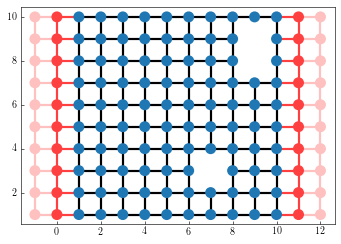

In [616]:
sys, lead = make_disordered_system(seed=2, length=10, width=10, nvac=3)
kwant.plot(sys);

# 1.5 Aharonov-Bohm oscillations

In [620]:
def make_ring(t=1.0, out_radius=10, in_radius=5, width=4, length=5.):
    
    def lead_along_x(pos):
        x, y = pos
        return abs(y) < 0.5*width

    def system_shape(pos):
        x, y = pos
        r = np.sqrt(x**2 + y**2)
        in_outer = r < out_radius 
        in_inner = r < in_radius
        in_ring = in_outer and not in_inner
        return in_ring
    
    def bfield(site1, site2, flux):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        if x1 == -1 and y1 < 0 and y1 == y2: 
            hop =  -t*np.exp(-1j*flux)
        else:
            hop =  -t
        return hop
    
    sys = kwant.Builder()
    lat = kwant.lattice.square(norbs=1)

    v1, v2 = lat.prim_vecs

    left_direction = kwant.TranslationalSymmetry(-v1)
    lead_left = kwant.Builder(left_direction)

    r_cent = 0.5*(in_radius + out_radius)
    sys[lat.shape(system_shape, (r_cent, 0))] = 0.0
    sys[lat.neighbors()] = bfield  

    lead_left[lat.shape(lead_along_x, (0, 0))] = 0.
    lead_left[lat.neighbors()] = -t

    sys.attach_lead(lead_left)
    sys.attach_lead(lead_left.reversed())
    
    sys_f = sys.finalized()         # Create finalized sytem
    lead_f = lead_left.finalized()  # Create finalized lead
    return sys_f, lead_f

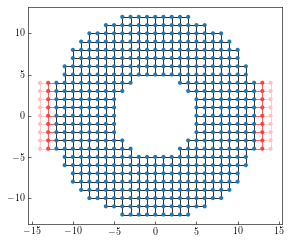

In [618]:
ring_sys, lead = make_ring(in_radius=5, out_radius=13, width=10, length=20)
kwant.plot(ring_sys);

### 1.5.1 Transmission at zero magnetic field

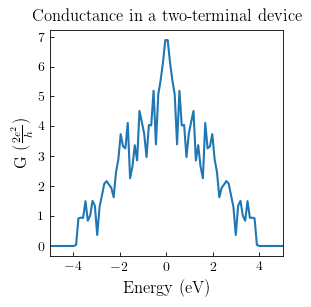

In [621]:
t10 = []       # Transmission from lead 0 to lead 1
energies = np.linspace(-5, 5, 100)

for energy in energies:
    smatrix = kwant.smatrix(ring_sys, energy, params={'flux':0.})
    t10.append(smatrix.transmission(1, 0))
    
plt.figure(dpi=100, figsize=(3, 3));
plt.plot(energies, t10, color='C0');
plt.xlabel('Energy (eV)', fontsize=12);
plt.title('Conductance in a two-terminal device', fontsize=12)
plt.ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=12);
plt.xlim(-5, 5);

### 1.5.2 Aharonov-Bohm oscillations

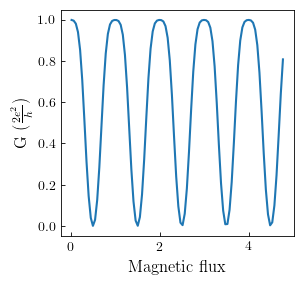

In [460]:
t10 = []       # Transmission from lead 0 to lead 1
fluxes = np.linspace(0.1, 30., 100)

for flux in fluxes:
    smatrix = kwant.smatrix(ring_sys, 3.85, params={'flux': flux})
    t10.append(smatrix.transmission(1, 0))
    
plt.figure(dpi=100, figsize=(3, 3));
plt.plot(fluxes/(2*np.pi), t10, color='C0');
plt.xlabel('Magnetic flux', fontsize=12);
plt.ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=12);

# 2. B&uuml;ttiker dephasing

Introducing an additional third lead in a two-terminal device will
lead to B&uuml;ttiker dephasing, where the dephased transmission $\tilde{T}_{21}$
between leads 1 and 2 is given by

$$ \tilde{T}_{21}(E) = T_{\rm coherent}(E) + T_{\rm incoherent}(E) =
T_{21}(E) + \frac{T_{23}(E)T_{31}(E)}{T_{31}(E) + T_{23}(E)}
$$

First, we will modify our <code>make_ring</code> function, so that the system now
has three leads. Also, we will add an option to switch from ring into a rectangle

In [103]:
def make_buttiker_system(t=1.0, out_radius=10, in_radius=5, width=4, length=20.,
                         lead_pos=0, make_ring=True, attach_probe=True,
                         pot=0):
    
    def lead_along_x(pos):
        x, y = pos
        return abs(y) <= 0.5*width
    
    def lead_along_y(pos):
        x, y = pos
        return abs(x-lead_pos) <= 0.5*width

    def ring_shape(pos):
        x, y = pos
        r = np.sqrt(x**2 + y**2)
        in_outer = r < out_radius 
        in_inner = r < in_radius
        in_ring = in_outer and not in_inner
        return in_ring
    
    def pot_function(site):
        """Add potential close to the left lead"""
        x, y = site.pos
        if make_ring:
            if (x < -out_radius + 3):
                V = pot
            else:
                V = 0
        else:
            if (x < -0.5*length + 3):
                V = pot
            else:
                V = 0
        return V
    
    def rectangle(pos):
        x, y = pos
        in_x = abs(x) <= 0.5*length
        in_y = abs(y) <= 0.5*width
        return in_x and in_y
    
    sys = kwant.Builder()
    lat = kwant.lattice.square(norbs=1)

    v1, v2 = lat.prim_vecs

    left_direction = kwant.TranslationalSymmetry(-v1)
    left_lead = kwant.Builder(left_direction)
    
    down_direction = kwant.TranslationalSymmetry(-v2)
    down_lead = kwant.Builder(down_direction)

    r_cent = 0.5*(in_radius + out_radius)
    
    if make_ring:
        sys[lat.shape(ring_shape, (r_cent, 0))] = pot_function
    else:
        if abs(lead_pos) > 0.5*(length-width):
            raise ValueError('Bad lead_pos parameter. Please set it within'
                             'the (-length/2+width/2, lenght/2-width/2) range')
        sys[lat.shape(rectangle, (0, 0))] = pot_function
        
    sys[lat.neighbors()] = -t  

    left_lead[lat.shape(lead_along_x, (0, 0))] = 0.
    left_lead[lat.neighbors()] = -t
    
    down_lead[lat.shape(lead_along_y, (lead_pos, 0))] = 0.
    down_lead[lat.neighbors()] = -t
    
    # Pay attention to the order in which the leads are
    # attached.
    sys.attach_lead(left_lead)
    sys.attach_lead(left_lead.reversed())
    if attach_probe:
        sys.attach_lead(down_lead)    
    
    
    sys_f = sys.finalized()         # Create finalized sytem
    lead_f = left_lead.finalized()  # Create finalized lead
    return sys_f, lead_f

### 2.1 Dephasing transmission as a function of energy

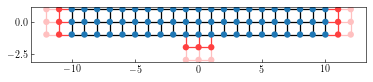

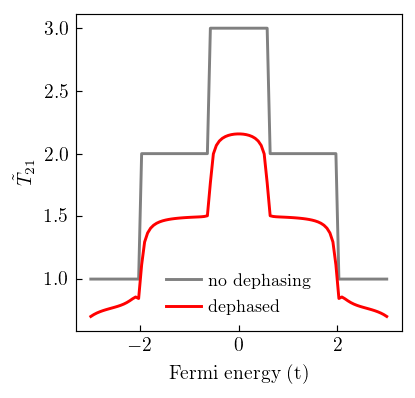

In [108]:
# Make the system with three leads
sys_3lead, lead = make_buttiker_system(out_radius=10, in_radius=5, length=20.,
                                      width=2, lead_pos=0, make_ring=False)

# Make identical system, but only with two leads
sys_2lead, lead = make_buttiker_system(out_radius=10, in_radius=5, length=20.,
                                       width=2, lead_pos=0, make_ring=False,
                                       attach_probe=False)
kwant.plot(sys_3lead);

energies = np.linspace(-3, 3, 100)
t_3lead = []
t_2lead = []

for e in energies:
    smatrix_3lead = kwant.smatrix(sys_3lead, e)
    smatrix_2lead = kwant.smatrix(sys_2lead, e)
    t21 = smatrix_3lead.transmission(1, 0)
    t31 = smatrix_3lead.transmission(2, 0)
    t23 = smatrix_3lead.transmission(1, 2)
    t_3lead.append(t21 + (t23*t31)/(t23+t31))
    
    t_2lead.append(smatrix_2lead.transmission(1, 0))

plt.figure(dpi=140, figsize=(3, 3))
plt.plot(energies, t_2lead, color='gray', label='no dephasing')
plt.plot(energies, t_3lead, color='red', label='dephased')
plt.legend()
plt.xlabel('Fermi energy (t)');
plt.ylabel('$\\tilde{T}_{21}$ ');
    

### 2.2 Dephasing transmission as a function of lead position

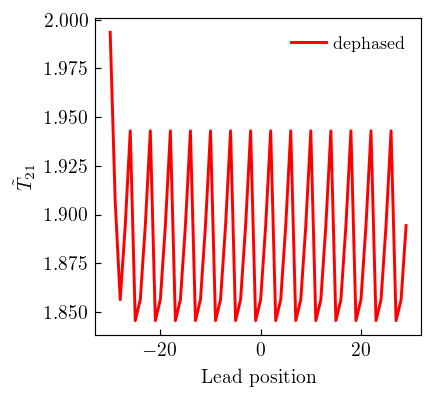

In [109]:

positions = np.arange(-30, 30)
t_3lead = []

for pos in positions:
    sys_3lead, lead = make_buttiker_system(length=62., pot=0.5,
                                           width=2, lead_pos=pos, make_ring=False)
    smatrix_3lead = kwant.smatrix(sys_3lead, 0.)
    t21 = smatrix_3lead.transmission(1, 0)
    t31 = smatrix_3lead.transmission(2, 0)
    t23 = smatrix_3lead.transmission(1, 2)
    t_3lead.append(t21 + (t23*t31)/(t23+t31))

plt.figure(dpi=140, figsize=(3, 3))
plt.plot(positions, t_3lead, color='red', label='dephased')
plt.legend()
plt.xlabel('Lead position');
plt.ylabel('$\\tilde{T}_{21}$ ');
    

# 3. Spin Hall effect in a four-terminal device

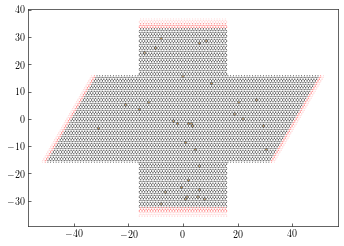

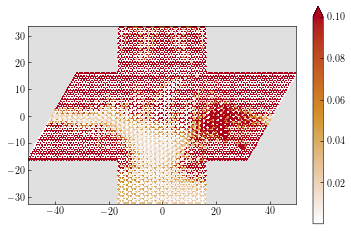

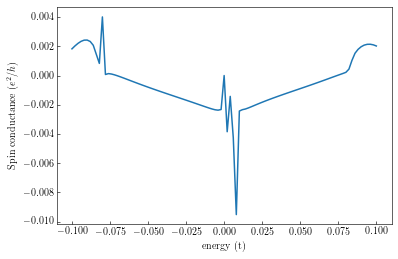

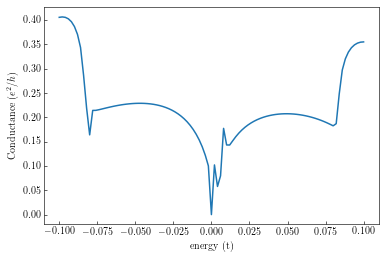

 Energy = 0.100000

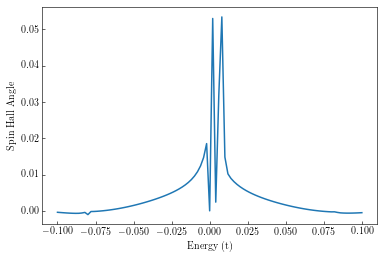

In [126]:
from math import sqrt
import random
import itertools as it
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import kwant
from sympy import S, Eq, solve, Symbol


class Honeycomb(kwant.lattice.Polyatomic):
    """Honeycomb lattice with methods for dealing with hexagons"""

    def __init__(self, name=''):
        prim_vecs = [[0.5, sqrt(3)/2], [1, 0]]  # Bravais lattice vectors
        # offset the lattice so that it is symmetric around x and y axes
        basis_vecs = [[-0.5, -1/sqrt(12)], [-0.5, 1/sqrt(12)]]
        super(Honeycomb, self).__init__(prim_vecs, basis_vecs, name)
        self.a, self.b = self.sublattices

    def hexagon(self, tag):
        """ Get sites belonging to hexagon with the given tag.
            Returns sites in counter-clockwise order starting
            from the lower-left site.
        """
        tag = ta.array(tag)
        #         a-sites b-sites
        deltas = [(0, 0), (0, 0),
                  (1, 0), (0, 1),
                  (0, 1), (-1, 1)]
        lats = it.cycle(self.sublattices)
        return (lat(*(tag + delta)) for lat, delta in zip(lats, deltas))

    def hexagon_neighbors(self, tag, n=1):
        """ Get n'th nearest neighbor hoppings within the hexagon with
            the given tag.
        """
        hex_sites = list(self.hexagon(tag))
        return ((hex_sites[(i+n)%6], hex_sites[i%6]) for i in range(6))

def random_placement(builder, lattice, density):
    """ Randomly selects hexagon tags where adatoms can be placed.
        This avoids the edge case where adatoms would otherwise
        be placed on incomplete hexagons at the system boundaries.
    """
    assert 0 <= density <= 1
    system_sites = builder.sites()

    def hexagon_in_system(tag):
        return all(site in system_sites for site in lattice.hexagon(tag))

    # get set of tags for sites in system (i.e. tags from only one sublattice)
    system_tags = (s.tag for s in system_sites if s.family == lattice.a)
    # only allow tags which have complete hexagons in the system
    valid_tags = list(filter(hexagon_in_system, system_tags))
    N = int(density * len(valid_tags))
    total_hexagons=len(valid_tags)
    valuef=random.sample(valid_tags, N)
    return valuef

def cross(W, L):
    def shape(pos):
        return ((-W <= pos[0] <= W and -L <= pos[1] <= L) or  # vertical
                (-W <= pos[1] <= W and -L <= pos[0] <= L))    # horizontal
    return shape

## Pauli matrices ##
sigma_0 = ta.array([[1, 0], [0, 1]])  # identity
sigma_x = ta.array([[0, 1], [1, 0]])
sigma_y = ta.array([[0, -1j], [1j, 0]])
sigma_z = ta.array([[1, 0], [0, -1]])

## Hamiltonian value functions ##

def onsite_potential(site, params):
    return params['ep'] * sigma_0

def potential_shift(site, params):
    return params['mu'] * sigma_0

def kinetic(site_i, site_j, params):
    return -params['gamma'] * sigma_0

def rashba(site_i, site_j, params):
    d_ij = site_j.pos - site_i.pos
    rashba = 1j * params['V_R'] * (sigma_x * d_ij[1] - sigma_y * d_ij[0])
    return rashba + kinetic(site_i, site_j, params)

def spin_orbit(site_i, site_j, params):
    so = (1j/3.) * params['V_I'] * sigma_z
    return so

lat = Honeycomb()
pv1, pv2 = lat.prim_vecs
ysym = kwant.TranslationalSymmetry(pv2 - 2*pv1)  # -y direction
xsym = kwant.TranslationalSymmetry(-pv2)         # -x direction

# Adatom lattice, for visualization only
adatom_lat = kwant.lattice.Monatomic(lat.prim_vecs, name='adatom')

def site_size(s):                                          
    return 0.25 if s.family in lat.sublattices else 0.35

def site_color(s): 
    return '#000000' if s.family in lat.sublattices else '#de962b'

def create_lead_h(W, symmetry, axis=(0, 0)):
    lead = kwant.Builder(symmetry)
    lead[lat.wire(axis, W)] = 0. * sigma_0
    lead[lat.neighbors(1)] = kinetic
    return lead

def create_lead_v(L,W, symmetry):
    axis=(0, 0)
    lead = kwant.Builder(symmetry)
    lead[lat.wire(axis, W)] = 0. * sigma_0
    lead[lat.neighbors(1)] = kinetic
    return lead

def create_hall_cross(W, L, adatom_density=0.2, show_adatoms=False):
    ## scattering region ##
    sys = kwant.Builder()
    sys[lat.shape(cross(W, L), (0, 0))] = onsite_potential
    sys[lat.neighbors(1)] = kinetic

    adatoms = random_placement(sys, lat, adatom_density)

    sys[(lat.hexagon(a) for a in adatoms)] = potential_shift
    sys[(lat.hexagon_neighbors(a, 1) for a in adatoms)] = rashba
    sys[(lat.hexagon_neighbors(a, 2) for a in adatoms)] = spin_orbit
    if show_adatoms:
        # no hoppings are added so these won't affect the dynamics; purely cosmetic
        sys[(adatom_lat(*a) for a in adatoms)] = 0
    ## leads ##
    leads = [create_lead_h(W, xsym)]
    leads += [create_lead_v(L,W, ysym)]
    leads += [lead.reversed() for lead in leads]  # right and bottom leads
    for lead in leads:
        sys.attach_lead(lead)
    return sys

def plot_ldos(sys, Es, params):
    fsys = sys.finalized()
    ldos = kwant.ldos(fsys, energy=Es, args=(params,))
    ldos = ldos[::2] + ldos[1::2] # sum spins
    kwant.plotter.map(fsys, ldos, vmax=0.1)

def plot_conductance(sys, energies, lead_i, lead_j, params):
    fsys = sys.finalized()
    data = []

    for energy in energies:
        smatrix = kwant.greens_function(fsys, energy, args=(params,))
        data.append(smatrix.transmission(lead_i,lead_j))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy (t)")
    plt.ylabel(r'Conductance ($e^2/h$)')
    plt.show()

def plot_spin_conductance(sys, energies,lead_i,lead_j, params):
    fsys = sys.finalized()
    data = []

    for energy in energies:
        smatrix = kwant.greens_function(fsys, energy, args=(params,))
        ttdagger = smatrix._a_ttdagger_a_inv(lead_i, lead_j)
        sigma_z_matrix = np.kron(np.eye(int(len(ttdagger)/2)),sigma_z)    
        data.append(np.trace(sigma_z_matrix.dot(ttdagger)).real)
    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy (t)")
    plt.ylabel(r'Spin conductance ($e^2/h$)')
    plt.show()

def solvematrix4(G,I0,I2,V1,V3):
    # I=GxV
    I1,I3,V0,V2=S('I1 I3 V0 V2'.split())
    equations = [Eq(I0, G[0][0]*V0+G[0][1]*V1+G[0][2]*V2+G[0][3]*V3), \
                 Eq(I1, G[1][0]*V0+G[1][1]*V1+G[1][2]*V2+G[1][3]*V3), \
                 Eq(I2, G[2][0]*V0+G[2][1]*V1+G[2][2]*V2+G[2][3]*V3), \
                 Eq(I3, G[3][0]*V0+G[3][1]*V1+G[3][2]*V2+G[3][3]*V3)]
    return solve(equations, [I1,I3,V0,V2], set=True, dict=False, rational=None, manual=True, minimal=True, particular=True, implicit=False, quick=True)

def plot_SH_angle(sys, energies, params):
    fsys = sys.finalized()
    data = []

    I0 = 0.
    I2 = 0.
    V1 = 1.
    V3 = 0.

    for energy in energies:
        print("\r Energy = %.5f" % energy, end='')
        smatrix = kwant.greens_function(fsys, energy, args=(params,))
        G = np.zeros((4, 4))
        for i in range(4):
            a = 0
            for j in range(4):
                G[i,j] = smatrix.transmission(i, j)
                if i != j: a+=G[i,j]
            G[i,i]=-a
        a = solvematrix4(G, I0, I2, V1, V3)[1]
        result = list(a)

        I1 = result[0][0]
        I3 = result[0][1]
        V0 = result[0][2]
        V2 = result[0][3]

        Gspin = np.zeros((4, 4))
        for i in range(4):
            a = 0
            for j in range(4):
                ttdagger = smatrix._a_ttdagger_a_inv(i, j)
                sigma_z_matrix = np.kron(np.eye(int(len(ttdagger)/2)),sigma_z)    
                Gspin[i,j] = np.trace(sigma_z_matrix.dot(ttdagger)).real
                if i != j: a+=Gspin[i,j]
            Gspin[i,i]=-a

        IS0 = Gspin[1,0] * (V1-V0) + Gspin[2,0]*(V2-V0) + Gspin[3,0] * (V3-V0)
        data.append(IS0/I1)

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("Energy (t)")
    plt.ylabel("Spin Hall Angle")
    plt.show()

if __name__ == '__main__':
    params = dict(gamma=1., ep=0, mu=0.1, 
                  V_I=0.007, V_R=0.0165)  # Au adatoms

    W = 16
    L = 32
    adatom_density=0.01
    # adatom_density=0.15
    # W = 8
    # L = 16

    sys = create_hall_cross(W, L, adatom_density, show_adatoms=True)
    kwant.plot(sys, site_color=site_color, site_size=site_size)

    sys = create_hall_cross(W, L, adatom_density, show_adatoms=False)
    plot_ldos(sys, 1e-5, params)
    
    Es = np.linspace(-0.1, 0.1, 101)
    plot_spin_conductance(sys, Es, 1, 0, params)   # T01
    plot_conductance(sys, Es, 1, 0, params)        # TS01

    plot_SH_angle(sys, Es, params)

# 4. Topological Hall effect in a four-terminal device  due to skyrmion

A magnetic texture placed on top of the tight-binding system, for instance a skyrmion,
would modify its Hamiltonian

$$H = - t \sum_{\langle ij\rangle} |i\rangle\langle j| +
          \sum_{i} V_i \ \ |i\rangle\langle i|$$
through its onsite energy
$$V_i = J \ m ( r) \cdot  \sigma $$

Here, the skyrmion is given by
$$ m ( r) = \left(x/r \sin\theta \ , \ y/r \sin\theta \ ,\  \cos\theta \right) $$

$$\theta (r) = \tanh \frac{r-r_0}{\delta}$$

### 4.1 Plotting the skyrmion

In [122]:
import matplotlib.pyplot as plt

def plot_skyrmion(r0=15, delta=5, nx=20, ny=20, rmax=30):
    x_points = np.linspace(-rmax, rmax, nx)
    y_points = np.linspace(-rmax, rmax, ny)
    x, y = np.meshgrid(x_points, y_points)
    r = np.sqrt(x**2 + y**2)
    theta = np.tanh((r0 - r)/delta)
    mx = (x/r)*np.sin(theta)
    my = (y/r)*np.sin(theta)
    mz = np.cos(theta)
   
    plt.figure(dpi=150, figsize=(3, 3))
    plt.quiver(x, y, mx, my, mz, cmap='bwr')
    plt.title('Magnetic texture (skyrmion)')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

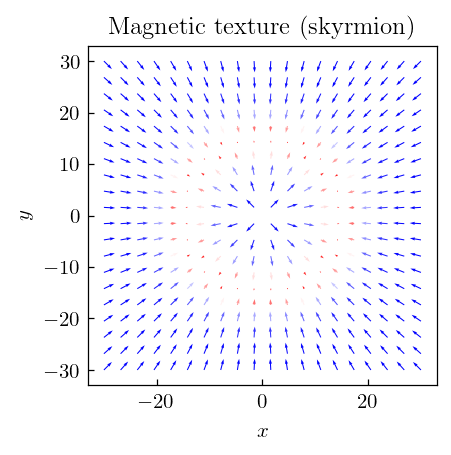

In [123]:
plot_skyrmion()

### 5.2 Computing the Hall resistance

According to the Landauer-B&uuml;ttiker formula, the conductance in a
four-terminal  device given in the matrix form is


$$ \left(\begin{matrix} I_1 \\ I_2 \\ I_3 \\ I_4 \end{matrix} \right) =
   \left(
     \begin{matrix}
     G_{12} + G_{13} + G_{14} & -G_{12} & -G_{13} & -G{14}  \\
     -G_{21} & G_{21} + G_{23} + G_{24} & -G_{23} & -G_{24} \\
     -G_{31} & -G_{32} &  G_{31}+ G_{32} + G_{34} & -G_{34} \\
     -G_{41} & -G_{42} &  -G_{43} & G_{41} + G_{42} + G_{43} 
     \end{matrix}
   \right)
   \left(
     \begin{matrix}
     V_1 \\ V_2 \\ V_3 \\ V_4
     \end{matrix}
   \right),
$$

where the leads are indexed in the clockwise direction starting from the left lead.
This system is not independent because current $I_4$ can be expressed using other three currents. Also, since currents only depend on voltage differences one voltage can be set as a reference point ($V_4 = 0$). The given system then reduces to three equations

$$ \left(\begin{matrix} I_1 \\ I_2 \\ I_3 \end{matrix} \right) =
   \left(
     \begin{matrix}
     G_{12} + G_{13} + G_{14} & -G_{12} & -G_{13}  \\
     -G_{21} & G_{21} + G_{23} + G_{24} & -G_{23}  \\
     -G_{31} & -G_{32} &  G_{31}+ G_{32} + G_{34}  \\
     \end{matrix}
   \right)
   \left(
     \begin{matrix}
     V_1 \\ V_2 \\ V_3
     \end{matrix}
   \right),
$$

Inverting the conductance matrix, we get the resistance matrix

$$ \left(\begin{matrix} V_1 \\ V_2 \\ V_3 \end{matrix} \right) =
   \left(
     \begin{matrix}
     R_{11} & R_{12} & R_{13}  \\
     R_{21} & R_{22} & R_{23}  \\
     R_{31} & R_{32} & R_{33}  \\
     \end{matrix}
   \right)
   \left(
     \begin{matrix}
     I_1 \\ I_2 \\ I_3
     \end{matrix}
   \right),
$$
that is $\mathbf{V} = \mathbf{R}\mathbf{I}$, where $\mathbf{R} = \mathbf{G}^{-1}$. 

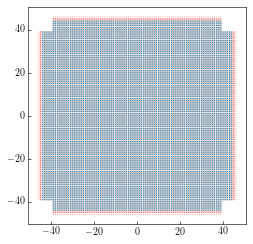

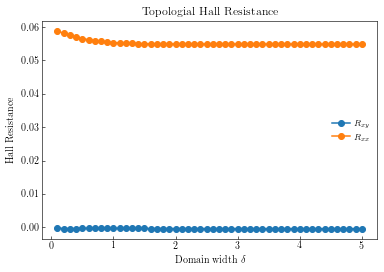

-6.48364913335799 6.48364913335797 0.513300899054389 0.549349094614334
-6.99396292881627 6.99396292881620 0.526946879224179 0.537608685148766
-7.15267611620984 7.15267611620990 0.512898304204094 0.546827622190681
-7.69183519537623 7.69183519537620 0.525966360373191 0.531301994303821
-7.81780346446233 7.81780346446236 0.514854137983168 0.540354444104231
-8.36144179265972 8.36144179265956 0.527973553010397 0.527193889930001
-8.50474334917862 8.50474334917865 0.517639131583068 0.532988598907662
-8.92000695518947 8.92000695518944 0.528895937895730 0.521508099874929
-9.19753778847506 9.19753778847500 0.525283409886001 0.522442660459126
-9.01334912588280 9.01334912588321 0.517562318413848 0.531247759376796
-11.5309735607951 11.5309735607953 0.538783055288450 0.499231755231223
-12.4045657714024 12.4045657714023 0.527462889325792 0.491148420696751
-13.8131533312288 13.8131533312288 0.527127631034005 0.481106260671112
-14.3179253048576 14.3179253048576 0.517109066065598 0.487978801335655
-15.11

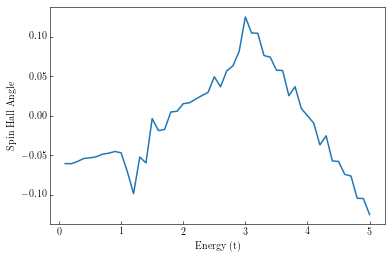

In [125]:
from types import SimpleNamespace
from matplotlib import pyplot
from math import cos, sin, pi
import numpy as np
import scipy.stats as reg
import kwant
from sympy import S, Eq, solve, Symbol

lat = kwant.lattice.square()

# Define unity and Pauli matrices
s_0 = np.identity(2)
s_z = np.array([[1, 0], [0, -1]])
s_x = np.array([[0, 1], [1, 0]])
s_y = np.array([[0, -1j], [1j, 0]])


def HedgeHog(site, ps):
    """Defines an onsite potential function in the 
    main scattering region due to coupling with magnetic
    texture.
    
    Parameters
    ----------
    site : site object
    ps : input parameters
    """
    
    x, y = site.pos
    r = (x**2 + y**2)**0.5
    theta = (np.pi/2)*(np.tanh((ps.r0 - r)/ps.delta) + 1)
    if r != 0:
        Ex = ((x/r)*np.sin(theta)*s_x +
              (y/r)*np.sin(theta)*s_y + 
              np.cos(theta)*s_z)
    else:
        Ex = s_z
    return 4*s_0 + ps.Ex * Ex
       

def Lead_Pot(site, ps):
    return  4*s_0 +  ps.Ex * s_z

def MakeSystem(ps, show=False):
    H  = kwant.Builder()

    def shape_2DEG(pos):
        # Defines a four-terminal cross region
        x, y = pos
        in_x = (abs(x) < ps.L) and (abs(y) < ps.W)
        in_y = (abs(x) < ps.W) and (abs(y) < ps.L)
        return in_x or in_y
    
    H[lat.shape(shape_2DEG,(0, 0))] = HedgeHog
    H[lat.neighbors()] = -s_0
    
    # Define lead along the x-direction
    sym_x = kwant.TranslationalSymmetry((-1,0))
    H_lead_x = kwant.Builder(sym_x)
    shape_x = lambda pos: abs(pos[1])<ps.W and pos[0]==0 
    H_lead_x[lat.shape(shape_x,(0,0))] = Lead_Pot
    H_lead_x[lat.neighbors()] = -s_0
  
    # Define lead along the y-direction
    sym_y = kwant.TranslationalSymmetry((0,-1))
    H_lead_y = kwant.Builder(sym_y)
    shape_y = lambda pos: abs(pos[0])<ps.W and pos[1]==0 
    H_lead_y[lat.shape(shape_y,(0,0))] = Lead_Pot 
    H_lead_y[lat.neighbors()] = -s_0
    
    H.attach_lead(H_lead_x)
    H.attach_lead(H_lead_y)
    H.attach_lead(H_lead_y.reversed())
    H.attach_lead(H_lead_x.reversed())
    
    if show:
        kwant.plot(H)
    return H
 

def Transport(Hf, EE, ps):
    smatrix = kwant.smatrix(Hf, energy=EE, args=[ps])
    G = np.zeros((4,4))
    for i in range(4):
        a = 0
        for j in range(4): 
            G[i, j] = smatrix.transmission(i, j)
            if i != j:
                a += G[i,j]
        G[i,i] = -a 
        
    V = np.linalg.solve(G[:3,:3], [1.,0,0])
    Hall = V[2] - V[1]
    
    V = np.linalg.solve(G[:3,:3], [1.,0,-1])
    Rxx = V[2] - V[0]
    
    
    return G, Hall, Rxx

# Define initial system parameters
ps = SimpleNamespace(L=45, W=40, delta=10, r0=20, Ex=1.)

H = MakeSystem(ps, show=True)
Hf = H.finalized()

def Vz(site):
    Hd = HedgeHog(site,ps)
    return (Hd[0,0] - Hd[1,1]).real 

def Vy(site):
    Hd = HedgeHog(site, ps)
    return Hd[0,1].imag 

# kwant.plotter.map(H, Vz);
# kwant.plotter.map(H, Vy);

# Hall Resistance
ps = SimpleNamespace(L=20, W=15, delta=3, r0=6, Ex=1.)

H = MakeSystem(ps, show=False)
Es = np.linspace(0.1,5.,50)
Hf = H.finalized()
dataG , dataHall, dataRxx = [],[], []

for EE in Es: 
    ps.delta = EE
    energy = 2.
    G, Hall, Rxx = Transport(Hf, energy, ps)
    dataHall.append(Hall)
    dataRxx.append(Rxx)

pyplot.plot(Es, dataHall, 'o-', label=r'$R_{xy}$')
pyplot.plot(Es, dataRxx, 'o-', label=r'$R_{xx}$')
pyplot.xlabel('Domain width $\delta$')
pyplot.ylabel('Hall Resistance')
pyplot.title('Topologial Hall  Resistance')
pyplot.legend();
pyplot.show()

# Spin Hall angle
def solvematrix4(G,I0,I2,V1,V3):
    # I=GxV
    I1, I3, V0, V2=S('I1 I3 V0 V2'.split())
    equations = [Eq(I0, G[0][0]*V0+G[0][1]*V1+G[0][2]*V2+G[0][3]*V3), \
                 Eq(I1, G[1][0]*V0+G[1][1]*V1+G[1][2]*V2+G[1][3]*V3), \
                 Eq(I2, G[2][0]*V0+G[2][1]*V1+G[2][2]*V2+G[2][3]*V3), \
                 Eq(I3, G[3][0]*V0+G[3][1]*V1+G[3][2]*V2+G[3][3]*V3)]
    return solve(equations, [I1,I3,V0,V2], set=True, dict=False, rational=None, manual=True, minimal=True, particular=True, implicit=False, quick=True)

def plot_SH_angle(fsys, energies, ps):
    data = []

    I0=0
    I2=0
    V1=1.0
    V3=0

    for energy in energies:
        smatrix = kwant.greens_function(fsys, energy, args=[ps])
        G=np.zeros((4,4))
        for i in range(4):
            a=0
            for j in range(4):
                G[i,j]=smatrix.transmission(i, j)
                if i != j: a+=G[i,j]
            G[i,i]=-a
        a=solvematrix4(G,I0,I2,V1,V3)[1]
        result=list(a)

        I1=result[0][0]
        I3=result[0][1]
        V0=result[0][2]
        V2=result[0][3]
        print(I1,I3,V0,V2)

        Gspin=np.zeros((4,4))
        for i in range(4):
            a=0
            for j in range(4):
                ttdagger = smatrix._a_ttdagger_a_inv(i, j)
                sigma_z_matrix = np.kron(np.eye(int(len(ttdagger)/2)),s_z)    
                Gspin[i,j]=np.trace(sigma_z_matrix.dot(ttdagger)).real
                if i != j: a+=Gspin[i,j]
            Gspin[i,i]=-a

        IS0=Gspin[1,0]*(V1-V0)+Gspin[2,0]*(V2-V0)+Gspin[3,0]*(V3-V0)
        data.append(IS0/I1)

    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("Energy (t)")
    pyplot.ylabel("Spin Hall Angle")
    pyplot.show()
    
plot_SH_angle(Hf, Es, ps)


Please send corrections to <code>petrovic@udel.edu</code>